todo:

- shuffle the data
- rerun the notebook on the entire dataset


In [1]:
from AR_functions import *

from sklearn.decomposition import PCA

/home/alex/.virtualenvs/python3_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alex/.virtualenvs/python3_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alex/.virtualenvs/python3_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alex/.virtualenvs/python3_ml/lib/python3

Num GPUs Available:  1



/home/alex/.virtualenvs/python3_ml/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alex/.virtualenvs/python3_ml/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alex/.virtualenvs/python3_ml/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alex/.virtualenvs/p

In [2]:
# set random seeds
tensorflow.set_random_seed(123)
np.random.seed(123)

In [3]:
# load the (flattened) dataset 
def load_dataset():
    num_classes=10

    # training set
    cifar10_dir = "./cifar-10-batches-py/"
    x_train = np.zeros((5, 10000, 32*32*3))
    y_train = np.zeros((5, 10000))
    for i in range(1, 6):
        batch_file = cifar10_dir+"data_batch_"+str(i)
        with open(batch_file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        x, y = batch[b'data'], batch[b'labels']
        x_train[i-1] = x
        y_train[i-1] = y
    x_train = np.vstack((x_train))
    y_train = np.hstack((y_train))

    # testing set
    test_file = "./cifar-10-batches-py/test_batch"
    x_test = np.zeros((10000, 32*32*3))
    y_test = np.zeros((10000))
    with open(test_file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    x, y = batch[b'data'], batch[b'labels']
    x_test = x
    y_test = y

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_dataset()

In [4]:
# normalize images 
x_train = x_train / 225
x_test = x_test / 225

In [5]:
# for now (testing the code) use only 2,000 sample images
x_train = x_train[:4000]
y_train = y_train[:4000]

x_test = x_test[:4000]
y_test = y_test[:4000]

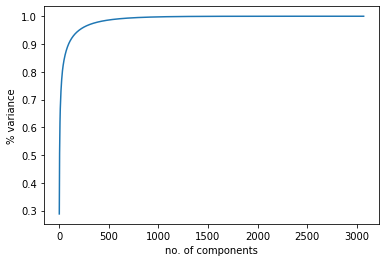

In [6]:
# PCA - first, choose the number of eigenvectors 
pca = PCA().fit(x_train)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('no. of components')
plt.ylabel('% variance')
plt.show()

In [7]:
# keep 80% of the variance?
k = 0 
var_cumsum = np.cumsum(pca.explained_variance_ratio_)

for cumsum in var_cumsum:
    if cumsum < 0.80:
        k+=1
    else:
        break
        
print("K = {}".format(k))

K = 31


In [8]:
pca_80 = PCA(n_components=k)
x_train_pca = pca_80.fit_transform(x_train)
x_test_pca = pca_80.fit_transform(x_test)

now that the data is transformed, use SVM

In [9]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

In [10]:
def linear_svm(c, x_train, y_train, x_test, y_test):
    clf = svm.SVC(probability=False, kernel='linear', C=c)
    clf.fit(x_train, y_train)
    
    print("C : {}".format(c))
    # accuracy on training set
    pred_train = clf.predict(x_train)
    train_score = clf.score(x_train, y_train)
    acc_train_lin.append(train_score)
    print('train score : {}'.format(train_score))
    
    # accuracy on testing set 
    pred_test = clf.predict(x_test)
    test_score = clf.score(x_test, y_test)
    acc_test_lin.append(test_score)
    print('test score : {}'.format(test_score))
    print(' ')
    
    #y_true = to_categorical(y_test, num_classes=10)
    #y_hat  = to_categorical(pred_test, num_classes=10)
    
    #for i in range(10):
    #    plt.subplot(2, 5, i+1)        
    #    fpr_test, tpr_test, _ = roc_curve(y_true[:, i], y_hat[:, i])
    #    plt.plot(fpr_test, tpr_test)
    #plt.show()

In [11]:
c_values = [0.0001, 0.001, 0.1, 1.0, 10]

acc_train_lin = []
acc_test_lin = []

for c in c_values:
    linear_svm(c, x_train_pca, y_train, x_test_pca, y_test)

C : 0.0001
train score : 0.2845
test score : 0.1165
 
C : 0.001
train score : 0.3825
test score : 0.11475
 
C : 0.1
train score : 0.40875
test score : 0.106
 
C : 1.0
train score : 0.4125
test score : 0.10425
 
C : 10
train score : 0.41375
test score : 0.1055
 


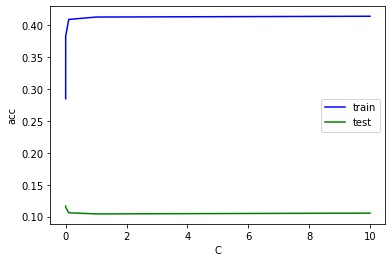

In [12]:
plt.plot(c_values, acc_train_lin, color='b', label='train')
plt.plot(c_values, acc_test_lin, color='g', label='test')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend()
plt.show()

In [13]:
def polynomial_svm(c, x_train, y_train, x_test, y_test):
    clf = svm.SVC(probability=False, kernel='poly', C=c)
    clf.fit(x_train, y_train)
    
    print("C : {}".format(c))
    # accuracy on training set
    pred_train = clf.predict(x_train)
    train_score = clf.score(x_train, y_train)
    acc_train_poly.append(train_score)
    print('train score : {}'.format(train_score))
    
    # accuracy on testing set 
    pred_test = clf.predict(x_test)
    test_score = clf.score(x_test, y_test)
    acc_test_poly.append(test_score)
    print('test score : {}'.format(test_score))
    print(' ')

In [14]:
c_values = [0.001, 0.01, 0.1, 1.0, 10.0]

acc_train_poly = []
acc_test_poly  = []

for c in c_values:
    polynomial_svm(c, x_train_pca, y_train, x_test_pca, y_test)

/home/alex/.virtualenvs/python3_ml/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


C : 0.001
train score : 0.39575
test score : 0.125
 


/home/alex/.virtualenvs/python3_ml/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


C : 0.01
train score : 0.7065
test score : 0.1335
 


/home/alex/.virtualenvs/python3_ml/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


C : 0.1
train score : 0.929
test score : 0.12175
 


/home/alex/.virtualenvs/python3_ml/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


C : 1.0
train score : 0.996
test score : 0.1265
 


/home/alex/.virtualenvs/python3_ml/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


C : 10.0
train score : 1.0
test score : 0.122
 


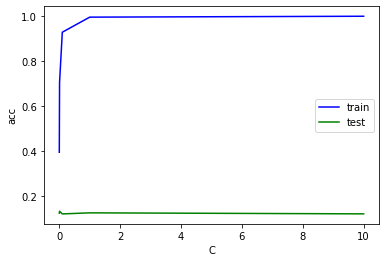

In [15]:
plt.plot(c_values, acc_train_poly, color='b', label='train')
plt.plot(c_values, acc_test_poly, color='g', label='test')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend()
plt.show()

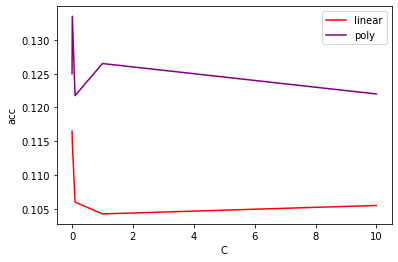

In [16]:
# compare test errors 
plt.plot(c_values, acc_test_lin, color='r', label='linear')
plt.plot(c_values, acc_test_poly, color='purple', label='poly')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend()
plt.show()

In [17]:
# the one that did best was polynomial with c=0.01
# this is only temporal. expected to change after training on all the data and with a 
# larger k. the value of C will probably be less then

# train on all the data
(x_train, y_train), (x_test, y_test) = load_dataset()
x_train = x_train / 225
x_test = x_test / 225
pca_90 = PCA(n_components=k)
x_train_pca = pca_90.fit_transform(x_train)
x_test_pca = pca_90.fit_transform(x_test)

In [18]:
svc = svm.SVC(probability=False, kernel='linear', C=0.01)
svc.fit(x_train_pca, y_train)
pred_test = svc.predict(x_test_pca)
acc_test = np.mean(pred_test == y_test)
print('test accuracy : ', acc_test)

test accuracy :  0.2127


In [19]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

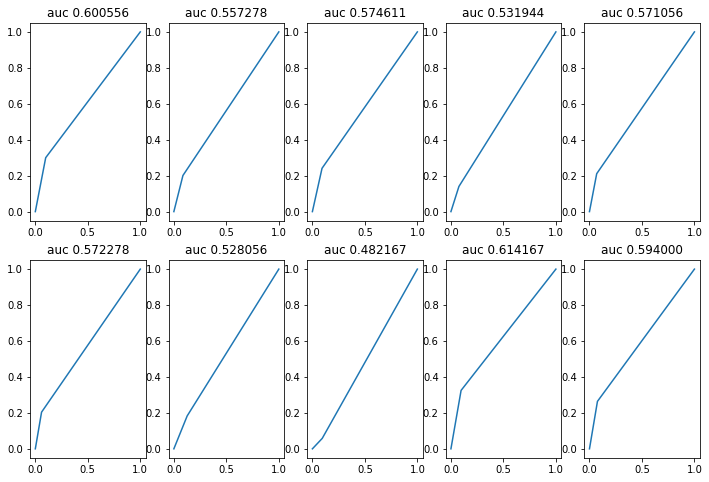

In [30]:
# ROC curve and auc
y_true = to_categorical(y_test, num_classes=10)
y_hat  = to_categorical(pred_test, num_classes=10)

plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)        
    fpr_test, tpr_test, _ = roc_curve(y_true[:, i], y_hat[:, i])
    auc = roc_auc_score(y_true[:, i], y_hat[:, i])
    plt.title('auc {0:f}'.format(auc))
    plt.plot(fpr_test, tpr_test)
plt.show()